Студент: `Борисов Дмитрий`

Группа: `MADE-ML-32`

In [1]:
import gym
import pandas as pd
import itertools
from tqdm.notebook import tqdm
import numpy as np
from collections import Counter, defaultdict

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,5)
legend_fontsize = 16

Загрузим среду

In [3]:
env = gym.make('Blackjack-v0')

print(env.action_space)
actions = {'stand': 0, 'hit': 1}
reversed_actions = {value: key for key, value in actions.items()}

Discrete(2)


# Часть первая, с блекджеком и стратегиями

**Задание 1.** Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [4]:
def simple_policy(observation):
    action = 'stand' if observation in (19, 20, 21) else 'hit'
    return actions[action]

In [5]:
n_experiments = 200_000
rewards = []
total_steps = []

for _ in tqdm(range(n_experiments)):
    observation = env.reset()
    
    n_steps = 0
    while True:
        action = simple_policy(observation[0])
        
        if action == actions['hit']:
            n_steps += 1
        
        observation, reward, done, info = env.step(action)
        if done:
            rewards.append(reward)
            total_steps.append(n_steps)
            break

print(f'Ожидаемый выигрыш для simple_policy: {np.mean(rewards):.4f}')
print(f'Среднее количество ходов алгоритма: {np.mean(total_steps):.4f}')
print(f'Минимальное количество ходов алгоритма: {np.min(total_steps)}')
print(f'Максимальное количество ходов алгоритма: {np.max(total_steps)}')


Ожидаемый выигрыш для simple_policy: -0.2030
Среднее количество ходов алгоритма: 1.2387
Минимальное количество ходов алгоритма: 0
Максимальное количество ходов алгоритма: 7


   reward   count
0    -1.0  112824
1     0.0   14953
2     1.0   72223


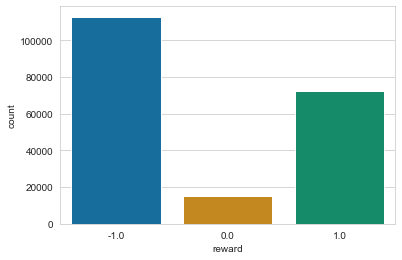

In [6]:
data = pd.DataFrame(sorted(Counter(rewards).items()), columns=['reward', 'count'])
print(data)
sns.barplot(x='reward', y='count', data=data);

   steps  count
0      0  42505
1      1  88639
2      2  50948
3      3  14821
4      4   2726
5      5    324
6      6     35
7      7      2


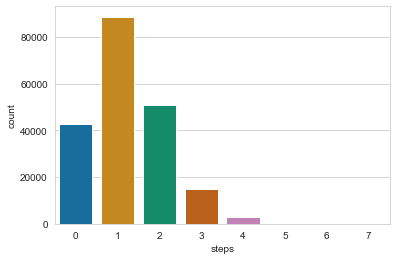

In [7]:
data = pd.DataFrame(sorted(Counter(total_steps).items()), columns=['steps', 'count'])
print(data)
sns.barplot(x='steps', y='count', data=data);

**Задание 2.** Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [8]:
def eps_soft_policy(eps, Q_s):
    if np.random.rand() > eps: 
        return np.argmax(Q_s)
    else:
        return np.random.randint(len(Q_s))

In [9]:
def generate_episode(env, policy, Q, eps):
    observations = []
    actions = []
    rewards = []
    observation = env.reset()
 
    while True:
        observation = observation[:2]  # my_cards + dealer_cards
        action = policy(eps, Q[observation])
        next_observation, reward, done, _ = env.step(action)

        observations.append(observation)
        actions.append(action)
        rewards.append(reward)
        observation = next_observation

        if done:
            break

    return observations, actions, rewards

In [10]:
def mc_control(env, Q, policy, gamma, eps, weights):
    states, actions, rewards = generate_episode(env, policy, Q, eps)   
    G, W = 0, 1
    
    prob_best_action = 1 - (env.action_space.n - 1) * eps / env.action_space.n

    for i in range(len(rewards))[::-1]:
        state = states[i]
        action = actions[i]
        reward = rewards[i]

        G = gamma * G + reward
        weights[(state, action)] += W
        Q[state][action] += (G - Q[state][action]) * W / weights[(state, action)]
        
        a_star = np.argmax(Q[state])
        if a_star != action:
            break

        W = W / prob_best_action

In [11]:
def run_tests(env, Q, n_tests):
    rewards = []

    for _ in range(n_tests):
        observation = env.reset()
        
        while True:
            action = Q[observation[:2]].argmax()
            observation, reward, done, _ = env.step(action)
            if done:
                rewards.append(reward)
                break
                
    return np.mean(rewards)

In [12]:
def exp_with_results_mc(env, update_Q_func, eps_policy, n_episodes, test_freq, gamma, eps, n_tests=1000):
    results = []

    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    weights = defaultdict(lambda: 0)

    for n in range(n_episodes + 1):
        update_Q_func(env, Q, eps_policy, gamma, eps, weights)

        if n % test_freq == 0:
            result = run_tests(env, Q, n_tests)
            results.append(result)

    return results, Q

**Задание 3.** Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [13]:
# Hyper parameters
n_episodes = 100_000
test_freq = 1_000
gammas = np.arange(0.5, 1.0001, 0.1)
epsilons = np.arange(0.05, 0.3, 0.1)

In [14]:
run_results = dict()
best_params, max_mean_reward = None, -float('inf')

for gamma, eps in itertools.product(gammas, epsilons):
    rewards, Q = exp_with_results_mc(
        env,
        mc_control,
        eps_soft_policy,
        n_episodes,
        test_freq,
        gamma,
        eps,
    )
    
    run_results[(gamma, eps)] = (rewards, Q)
    mean_reward = np.mean(rewards)
    print(f'gamma = {gamma:.4f}, eps = {eps:.4f}, mean_reward = {mean_reward:.6f}')
    
    if mean_reward > max_mean_reward:
        max_mean_reward = mean_reward
        best_params = (gamma, eps)
        
print()
print('Оптимальные гиперпараметры:')
print(f'gamma = {best_params[0]:.4f}, eps = {best_params[1]:.4f}')
print(f'Средний доход во время обучения = {max_mean_reward:.6f}')

gamma = 0.5000, eps = 0.0500, mean_reward = -0.076495
gamma = 0.5000, eps = 0.1500, mean_reward = -0.067891
gamma = 0.5000, eps = 0.2500, mean_reward = -0.057594
gamma = 0.6000, eps = 0.0500, mean_reward = -0.080426
gamma = 0.6000, eps = 0.1500, mean_reward = -0.073040
gamma = 0.6000, eps = 0.2500, mean_reward = -0.066248
gamma = 0.7000, eps = 0.0500, mean_reward = -0.072059
gamma = 0.7000, eps = 0.1500, mean_reward = -0.070158
gamma = 0.7000, eps = 0.2500, mean_reward = -0.064871
gamma = 0.8000, eps = 0.0500, mean_reward = -0.068535
gamma = 0.8000, eps = 0.1500, mean_reward = -0.068535
gamma = 0.8000, eps = 0.2500, mean_reward = -0.066733
gamma = 0.9000, eps = 0.0500, mean_reward = -0.081366
gamma = 0.9000, eps = 0.1500, mean_reward = -0.074752
gamma = 0.9000, eps = 0.2500, mean_reward = -0.062564
gamma = 1.0000, eps = 0.0500, mean_reward = -0.081822
gamma = 1.0000, eps = 0.1500, mean_reward = -0.070109
gamma = 1.0000, eps = 0.2500, mean_reward = -0.068693

Оптимальные гиперпараметры:

Ожидаемый выигрыш уже лучше, чем у простой стратегии, но все равно еще отрицательный

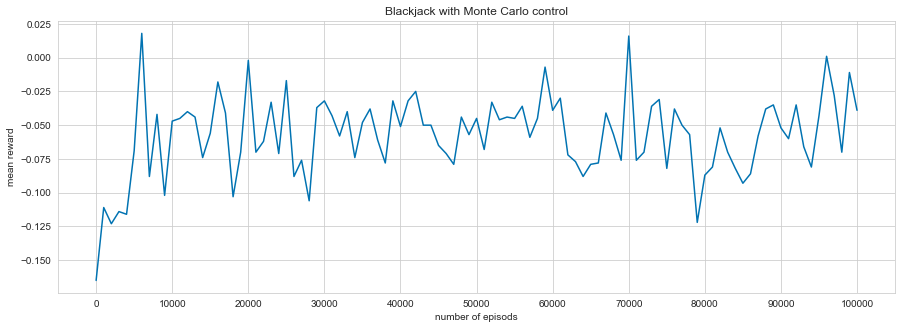

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
data = run_results[best_params][0]
ax.plot(data)

ax.set_xlabel('number of episods')
ax.set_ylabel('mean reward')
ax.set_title('Blackjack with Monte Carlo control')

ax.set_xticks(list(range(len(data)))[::10])
ax.set_xticklabels(list(range(0, n_episodes + 1, test_freq))[::10])
plt.plot();

In [16]:
Q = run_results[best_params][1]

# calculate my card sums
my_sums_arr = [x[0] for x in Q.keys()]
my_min_sum = min(my_sums_arr)
my_max_sum = max(my_sums_arr)

# calculate dealer card sums
dealer_sums_arr = [x[1] for x in Q.keys()]
dealer_min_sum = min(dealer_sums_arr)
dealer_max_sum = max(dealer_sums_arr)

In [17]:
# table for actions
table = [
    ['?'] * (dealer_max_sum - dealer_min_sum + 1)
    for _ in range(my_max_sum - my_min_sum + 1)
]

# fill this table
for (my_sum, dealer_sum), q_values in Q.items():
    my_sum -= my_min_sum
    dealer_sum -= dealer_min_sum

    action = reversed_actions[q_values.argmax()]
    table[my_sum][dealer_sum] = action

In [18]:
# table to DataFrame
columns = list(map(str, range(dealer_min_sum, dealer_max_sum + 1)))
indexes = list(map(str, range(my_min_sum, my_max_sum + 1)))
blackjack_actions_table = pd.DataFrame(table, index=indexes, columns=columns)
blackjack_actions_table = blackjack_actions_table.style.set_caption("My cards sum / Dealer's open card")
blackjack_actions_table

,1,2,3,4,5,6,7,8,9,10
4,hit,hit,hit,hit,stand,hit,hit,hit,hit,hit
5,hit,hit,hit,hit,stand,hit,hit,hit,hit,hit
6,hit,hit,hit,stand,hit,stand,hit,hit,hit,hit
7,hit,hit,hit,hit,stand,hit,hit,hit,hit,hit
8,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
9,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
10,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
11,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
12,hit,stand,stand,stand,stand,stand,hit,hit,hit,hit
13,hit,stand,stand,stand,stand,stand,hit,hit,hit,hit


Немного странно видеть при наших позициях 4-7 рекомендацию пассовать, но, скорее всего, алгоритм просто не дообучился

# Часть вторая, удвоенная

**Задание 4.** Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [19]:
from blackjack_double import DoubleBlackjackEnv

env = DoubleBlackjackEnv()
print(env.action_space)
actions = {'stand': 0, 'hit': 1, 'double': 2}
reversed_actions = {value: key for key, value in actions.items()}

Discrete(3)


**Задание 5.** Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [20]:
# Hyper parameters
n_episodes = 100_000
test_freq = 1_000
gammas = np.arange(0.5, 1.0001, 0.1)
epsilons = np.arange(0.05, 0.3, 0.1)

In [21]:
run_results = dict()
best_params, max_mean_reward = None, -float('inf')

for gamma, eps in itertools.product(gammas, epsilons):
    rewards, Q = exp_with_results_mc(
        env,
        mc_control,
        eps_soft_policy,
        n_episodes,
        test_freq,
        gamma,
        eps,
    )
    
    run_results[(gamma, eps)] = (rewards, Q)
    mean_reward = np.mean(rewards)
    print(f'gamma = {gamma:.4f}, eps = {eps:.4f}, mean_reward = {mean_reward:.6f}')
    
    if mean_reward > max_mean_reward:
        max_mean_reward = mean_reward
        best_params = (gamma, eps)
        
print()
print('Оптимальные гиперпараметры:')
print(f'gamma = {best_params[0]:.4f}, eps = {best_params[1]:.4f}')
print(f'Средний доход во время обучения = {max_mean_reward:.6f}')

gamma = 0.5000, eps = 0.0500, mean_reward = -0.076416
gamma = 0.5000, eps = 0.1500, mean_reward = -0.067941
gamma = 0.5000, eps = 0.2500, mean_reward = -0.062089
gamma = 0.6000, eps = 0.0500, mean_reward = -0.076723
gamma = 0.6000, eps = 0.1500, mean_reward = -0.078634
gamma = 0.6000, eps = 0.2500, mean_reward = -0.057495
gamma = 0.7000, eps = 0.0500, mean_reward = -0.078396
gamma = 0.7000, eps = 0.1500, mean_reward = -0.069604
gamma = 0.7000, eps = 0.2500, mean_reward = -0.059653
gamma = 0.8000, eps = 0.0500, mean_reward = -0.085198
gamma = 0.8000, eps = 0.1500, mean_reward = -0.070495
gamma = 0.8000, eps = 0.2500, mean_reward = -0.068089
gamma = 0.9000, eps = 0.0500, mean_reward = -0.082792
gamma = 0.9000, eps = 0.1500, mean_reward = -0.071792
gamma = 0.9000, eps = 0.2500, mean_reward = -0.075683
gamma = 1.0000, eps = 0.0500, mean_reward = -0.086386
gamma = 1.0000, eps = 0.1500, mean_reward = -0.074356
gamma = 1.0000, eps = 0.2500, mean_reward = -0.081911

Оптимальные гиперпараметры:

Стоило бы увеличить количество эпизодов обучения, так как количество состояний возросло в 1.5 раза. Но всё делается в последний момент, а считается не супер быстро.

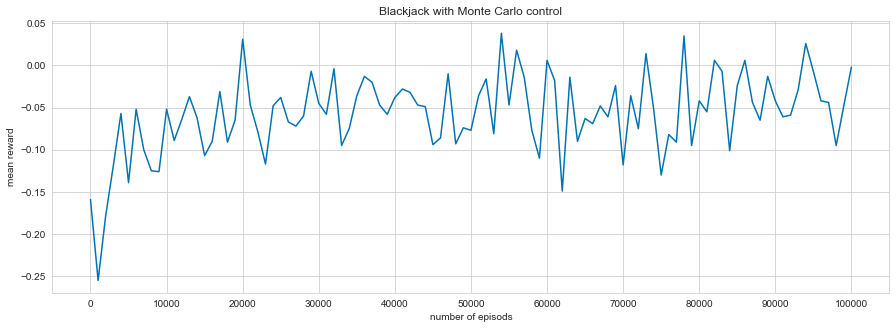

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
data = run_results[best_params][0]
ax.plot(data)

ax.set_xlabel('number of episods')
ax.set_ylabel('mean reward')
ax.set_title('Blackjack with Monte Carlo control')

ax.set_xticks(list(range(len(data)))[::10])
ax.set_xticklabels(list(range(0, n_episodes + 1, test_freq))[::10])
plt.plot();

In [23]:
Q = run_results[best_params][1]

# calculate my card sums
my_sums_arr = [x[0] for x in Q.keys()]
my_min_sum = min(my_sums_arr)
my_max_sum = max(my_sums_arr)

# calculate dealer card sums
dealer_sums_arr = [x[1] for x in Q.keys()]
dealer_min_sum = min(dealer_sums_arr)
dealer_max_sum = max(dealer_sums_arr)

In [24]:
# table for actions
table = [
    ['?'] * (dealer_max_sum - dealer_min_sum + 1)
    for _ in range(my_max_sum - my_min_sum + 1)
]

# fill this table
for (my_sum, dealer_sum), q_values in Q.items():
    my_sum -= my_min_sum
    dealer_sum -= dealer_min_sum

    action = reversed_actions[q_values.argmax()]
    table[my_sum][dealer_sum] = action

In [25]:
# table to DataFrame
columns = list(map(str, range(dealer_min_sum, dealer_max_sum + 1)))
indexes = list(map(str, range(my_min_sum, my_max_sum + 1)))
blackjack_actions_table = pd.DataFrame(table, index=indexes, columns=columns)
blackjack_actions_table = blackjack_actions_table.style.set_caption("My cards sum / Dealer's open card")
blackjack_actions_table

,1,2,3,4,5,6,7,8,9,10
4,hit,hit,hit,stand,hit,hit,hit,hit,hit,hit
5,hit,hit,hit,hit,hit,stand,hit,hit,stand,hit
6,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
7,hit,hit,hit,hit,stand,hit,hit,hit,hit,hit
8,hit,double,hit,hit,hit,hit,hit,hit,hit,hit
9,hit,hit,hit,hit,double,double,double,hit,hit,hit
10,hit,double,double,hit,double,double,double,hit,double,hit
11,hit,double,double,double,double,double,double,double,double,hit
12,hit,double,double,hit,stand,stand,hit,hit,hit,hit
13,hit,hit,stand,double,stand,double,hit,hit,hit,hit


В некоторых случаях алгоритм действительно рекомендует удваивать ставку.

# Часть третья, в главной роли — Дастин Хоффман

**Задание 6.** Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде.

In [26]:
from blackjack_hoffman_double import HoffmanDoubleBlackjackEnv

env = HoffmanDoubleBlackjackEnv()
print(env.action_space)
actions = {'stand': 0, 'hit': 1, 'double': 2}
reversed_actions = {value: key for key, value in actions.items()}

Discrete(3)


In [27]:
# update functions
def generate_episode(env, policy, Q, eps):
    observations = []
    actions = []
    rewards = []
    observation = env.reset()
 
    while True:
        observation = observation[:3]  # my_cards + dealer_cards + score
        action = policy(eps, Q[observation])
        next_observation, reward, done, _ = env.step(action)

        observations.append(observation)
        actions.append(action)
        rewards.append(reward)
        observation = next_observation

        if done:
            break

    return observations, actions, rewards


def run_tests(env, Q, n_tests):
    rewards = []

    for _ in range(n_tests):
        observation = env.reset()
        
        while True:
            action = Q[observation[:3]].argmax()
            observation, reward, done, _ = env.step(action)
            if done:
                rewards.append(reward)
                break
                
    return np.mean(rewards)

**Задание 7.** Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [28]:
# Hyper parameters
n_episodes = 200_000
test_freq = 2_000
gammas = np.arange(0.5, 1.0001, 0.1)
epsilons = np.arange(0.05, 0.3, 0.1)

In [29]:
run_results = dict()
best_params, max_mean_reward = None, -float('inf')

for gamma, eps in itertools.product(gammas, epsilons):
    rewards, Q = exp_with_results_mc(
        env,
        mc_control,
        eps_soft_policy,
        n_episodes,
        test_freq,
        gamma,
        eps,
    )
    
    run_results[(gamma, eps)] = (rewards, Q)
    mean_reward = np.mean(rewards)
    print(f'gamma = {gamma:.4f}, eps = {eps:.4f}, mean_reward = {mean_reward:.6f}')
    
    if mean_reward > max_mean_reward:
        max_mean_reward = mean_reward
        best_params = (gamma, eps)
        
print()
print('Оптимальные гиперпараметры:')
print(f'gamma = {best_params[0]:.4f}, eps = {best_params[1]:.4f}')
print(f'Средний доход во время обучения = {max_mean_reward:.6f}')

gamma = 0.5000, eps = 0.0500, mean_reward = -0.123178
gamma = 0.5000, eps = 0.1500, mean_reward = -0.116366
gamma = 0.5000, eps = 0.2500, mean_reward = -0.113228
gamma = 0.6000, eps = 0.0500, mean_reward = -0.117861
gamma = 0.6000, eps = 0.1500, mean_reward = -0.114050
gamma = 0.6000, eps = 0.2500, mean_reward = -0.117842
gamma = 0.7000, eps = 0.0500, mean_reward = -0.135158
gamma = 0.7000, eps = 0.1500, mean_reward = -0.123525
gamma = 0.7000, eps = 0.2500, mean_reward = -0.119713
gamma = 0.8000, eps = 0.0500, mean_reward = -0.132624
gamma = 0.8000, eps = 0.1500, mean_reward = -0.129525
gamma = 0.8000, eps = 0.2500, mean_reward = -0.119198
gamma = 0.9000, eps = 0.0500, mean_reward = -0.127663
gamma = 0.9000, eps = 0.1500, mean_reward = -0.125386
gamma = 0.9000, eps = 0.2500, mean_reward = -0.116822
gamma = 1.0000, eps = 0.0500, mean_reward = -0.137495
gamma = 1.0000, eps = 0.1500, mean_reward = -0.118832
gamma = 1.0000, eps = 0.2500, mean_reward = -0.128208

Оптимальные гиперпараметры:

Пожалуй, здесь алгоритм тоже не сошелся к оптимуму

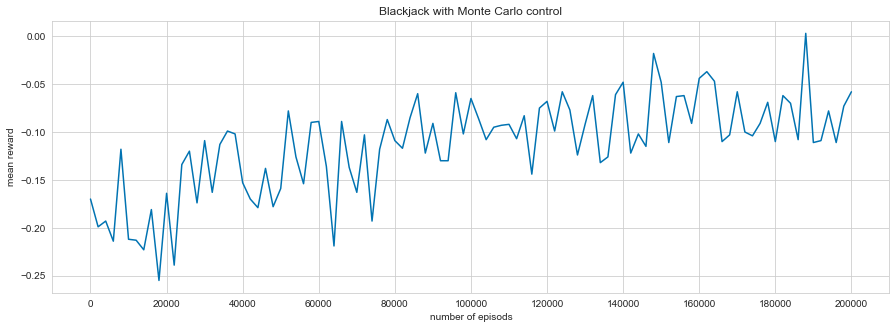

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
data = run_results[best_params][0]
ax.plot(data)

ax.set_xlabel('number of episods')
ax.set_ylabel('mean reward')
ax.set_title('Blackjack with Monte Carlo control')

ax.set_xticks(list(range(len(data)))[::10])
ax.set_xticklabels(list(range(0, n_episodes + 1, test_freq))[::10])
plt.plot();

Здесь в принципе виден рост в отличии от других случаев, поэтому есть надежды на сходимость данного алгоритма

In [31]:
Q = run_results[best_params][1]

# calculate my card sums
my_sums_arr = [x[0] for x in Q.keys()]
my_min_sum = min(my_sums_arr)
my_max_sum = max(my_sums_arr)

# calculate dealer card sums
dealer_sums_arr = [x[1] for x in Q.keys()]
dealer_min_sum = min(dealer_sums_arr)
dealer_max_sum = max(dealer_sums_arr)

In [32]:
# table for actions
table = [
    ['?'] * (dealer_max_sum - dealer_min_sum + 1)
    for _ in range(my_max_sum - my_min_sum + 1)
]

# fill this table
for (my_sum, dealer_sum, _), q_values in Q.items():
    my_sum -= my_min_sum
    dealer_sum -= dealer_min_sum

    action = reversed_actions[q_values.argmax()]
    table[my_sum][dealer_sum] = action

Эта таблица уже не отражает действительности, так как пространство состояний увеличилось в 40 раз, но пусть будет)

In [33]:
# table to DataFrame
columns = list(map(str, range(dealer_min_sum, dealer_max_sum + 1)))
indexes = list(map(str, range(my_min_sum, my_max_sum + 1)))
blackjack_actions_table = pd.DataFrame(table, index=indexes, columns=columns)
blackjack_actions_table = blackjack_actions_table.style.set_caption("My cards sum / Dealer's open card")
blackjack_actions_table

,1,2,3,4,5,6,7,8,9,10
4,hit,hit,stand,stand,hit,stand,hit,stand,stand,hit
5,stand,stand,hit,hit,stand,stand,stand,hit,stand,hit
6,stand,stand,hit,stand,hit,stand,hit,stand,hit,stand
7,stand,stand,stand,stand,stand,hit,stand,hit,stand,hit
8,stand,stand,stand,stand,stand,stand,hit,hit,hit,stand
9,hit,stand,stand,hit,stand,hit,stand,hit,hit,hit
10,hit,hit,stand,stand,stand,hit,double,stand,hit,hit
11,hit,stand,stand,double,hit,hit,hit,hit,stand,hit
12,hit,stand,hit,hit,stand,stand,stand,stand,stand,hit
13,stand,stand,stand,stand,stand,stand,hit,hit,stand,stand
